In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [38]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [60]:
rand_half_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 9))

In [61]:
rand_half_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287])

In [62]:
bvals_100206_half = bvals_all_100206[rand_half_bval_indice_100206]*1e-3

In [63]:
len(bvals_100206_half)


144

In [43]:
rand_half_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])

In [7]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [9]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [64]:
scan_100206_long_half = scan_100206_long[:, rand_half_bval_indice_100206]

In [65]:
scan_100206_long_half.shape

(3658350, 144)

In [66]:
indices_beginning_0 = np.where(scan_100206_long_half[:, 0] == 0)[0] # 2234485 before subsampling

In [67]:
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]  # 2234299

In [18]:
diff = np.setdiff1d(indices_beginning_0, indices_beginning_0_all)
print(diff)

[ 262497  263516  339198 ... 3265319 3266020 3268361]


In [19]:
print(indices_beginning_0)
print(indices_beginning_0_all)

[      0       1       2 ... 3658347 3658348 3658349]
[      0       1       2 ... 3658347 3658348 3658349]


In [68]:
len(indices_beginning_0)
# 2234299

2234485

In [69]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0] = 0

In [70]:
scan_100206_long_half_no_background = process_data.remove_background(scan_100206_long_half, mask_100206_long_pro)

In [71]:
S0_100206_half = process_data.get_S0(scan_100206_long_half_no_background, bvals_100206_half)

In [72]:
normalized_scan_100206_half = scan_100206_long_half_no_background / S0_100206_half

In [73]:
big_b_indices_100206_half = np.where(bvals_100206_half != 0.005)[0]

In [74]:
bvals_100206_half_no_b5 = bvals_100206_half[big_b_indices_100206_half]

In [75]:
normalized_scan_100206_half_no_b5 = normalized_scan_100206_half[:, big_b_indices_100206_half]

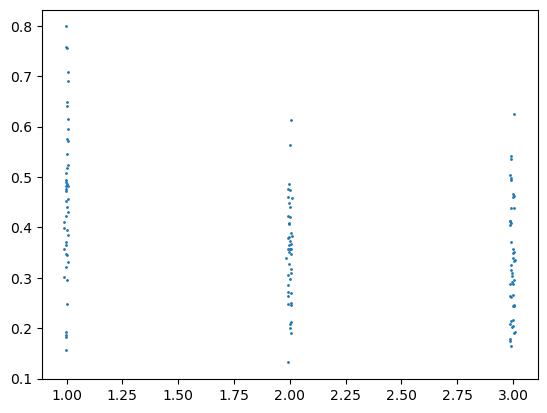

In [76]:
plt.plot(bvals_100206_half_no_b5, normalized_scan_100206_half_no_b5[42,:], "o", markersize = 1)

In [29]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [30]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [31]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [77]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_half = n_100206_all[:, rand_half_bval_indice_100206]

In [78]:
n_100206_all

array([[-0.542186,  0.918106, -0.382921,  0.097977,  0.20441 , -0.420482,
        -0.713198,  0.337916,  0.595529,  0.902882,  0.17268 ,  0.258874,
         0.84558 ,  0.409899,  0.976789,  0.293249, -0.542752,  0.9029  ,
         0.424887,  0.104118,  0.754053,  0.542995,  0.188334,  0.791947,
         0.304834,  0.697999,  0.438156,  0.793026,  0.307747,  0.486607,
         0.86747 ,  0.516189,  0.543239,  0.299074,  0.593076,  0.6197  ,
         0.220479,  0.235762,  0.844673,  0.900421,  0.28442 ,  0.03179 ,
         0.571379,  0.83342 ,  0.244202, -0.003766,  0.795861,  0.999893,
         0.543458,  0.040432,  0.948777,  0.074647,  0.643578,  0.058086,
         0.166397,  0.665435,  0.448909,  0.442191,  0.649559,  0.678402,
         0.051182,  0.582544,  0.585146,  0.750801,  0.543328,  0.131552,
         0.601377,  0.676446,  0.992241,  0.069078,  0.835667,  0.258221,
         0.412554,  0.913091,  0.614133, -0.757527,  0.267939,  0.572262,
         0.128238,  0.34743 ,  0.54131

In [36]:
n_100206_half

array([[-0.542752,  0.9029  ,  0.424887,  0.104118,  0.754053,  0.542995,
         0.188334,  0.791947,  0.304834,  0.697999,  0.438156,  0.793026,
         0.307747,  0.486607,  0.86747 ,  0.516189,  0.543239,  0.299074,
         0.593076,  0.6197  ,  0.220479,  0.235762,  0.844673,  0.900421,
         0.28442 ,  0.03179 ,  0.571379,  0.83342 ,  0.244202, -0.003766,
         0.795861,  0.999893,  0.543458,  0.040432,  0.948777,  0.074647,
         0.643578,  0.058086,  0.166397,  0.665435,  0.448909,  0.442191,
         0.649559,  0.678402,  0.051182,  0.582544,  0.585146,  0.750801,
         0.543328,  0.131552,  0.601377,  0.676446,  0.992241,  0.069078,
         0.835667,  0.258221,  0.412554,  0.913091,  0.614133, -0.757527,
         0.267939,  0.572262,  0.128238,  0.34743 ,  0.541318,  0.847558,
         0.337305,  0.542391,  0.66311 ,  0.930699,  0.078221,  0.172307,
         0.53662 ,  0.560125,  0.526839,  0.177254,  0.700596,  0.348817,
         0.828381,  0.53388 ,  0.18047

In [79]:
n_100206_half_no_b5 = n_100206_half[:,big_b_indices_100206_half].T
print(n_100206_half_no_b5.shape)

b_values_100206_half_no_b5 = torch.FloatTensor(bvals_100206_half_no_b5)
gradient_directions_100206_half_no_b5 = torch.FloatTensor(n_100206_half_no_b5)

net = BallStickNet(gradient_directions_100206_half_no_b5, b_values_100206_half_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(135, 3)


In [80]:
batch_size = 128
num_batches = len(normalized_scan_100206_half_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_half_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:36<00:00, 199.93it/s]


Loss: 325393.6607032716
Average Loss: 44.53177236940901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:43<00:00, 167.37it/s]


Loss: 324398.26676074415
Average Loss: 44.395547661248685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:37<00:00, 194.71it/s]


Loss: 324160.6664533019
Average Loss: 44.36303085442752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 215.41it/s]


Loss: 324150.5673895851
Average Loss: 44.36164874635077
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 216.46it/s]


Loss: 324141.3444099277
Average Loss: 44.360386534819725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:53<00:00, 137.56it/s]


Loss: 324138.64596477896
Average Loss: 44.3600172389187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:47<00:00, 153.98it/s]


Loss: 324136.65210630745
Average Loss: 44.35974436927705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:46<00:00, 155.93it/s]


Loss: 324133.7430034429
Average Loss: 44.35934624379949
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:38<00:00, 190.62it/s]


Loss: 324134.7565064877
Average Loss: 44.35948494683012
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:38<00:00, 187.66it/s]


Loss: 324131.03735306114
Average Loss: 44.358975961825806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|███                                                                                                                                                           | 143/7307 [00:03<00:51, 138.41it/s]

X_batch: 
torch.Size([128, 135])
tensor([[0.5028, 0.2746, 0.1948,  ..., 0.5177, 0.2713, 0.1380],
        [0.1193, 0.1306, 0.0875,  ..., 0.1065, 0.0822, 0.1308],
        [0.3550, 0.2073, 0.1561,  ..., 0.4132, 0.2306, 0.1472],
        ...,
        [0.5026, 0.2786, 0.3600,  ..., 0.4287, 0.3524, 0.1712],
        [0.4553, 0.3153, 0.2588,  ..., 0.4262, 0.2271, 0.3311],
        [0.5454, 0.3189, 0.3434,  ..., 0.5566, 0.3270, 0.2784]])
X_pred: 
torch.Size([128, 135])
tensor([[6.0645e-01, 4.3219e-01, 1.6412e-04,  ..., 2.3807e-01, 9.1561e-01,
         5.1618e-03],
        [6.3418e-01, 5.6448e-01, 2.2084e-04,  ..., 2.1318e-01, 9.1067e-01,
         8.8810e-03],
        [6.8993e-01, 5.9135e-01, 2.6975e-04,  ..., 2.2439e-01, 8.6109e-01,
         1.3502e-02],
        ...,
        [5.7635e-01, 6.2560e-01, 2.2181e-04,  ..., 1.8521e-01, 9.6047e-01,
         7.3215e-03],
        [7.2862e-01, 6.7916e-01, 3.7147e-04,  ..., 2.1890e-01, 8.3671e-01,
         2.1558e-02],
        [5.8884e-01, 6.0212e-01, 2.1621

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 215.44it/s]


Loss: 324133.69341958314
Average Loss: 44.359339457996875
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:34<00:00, 213.64it/s]


Loss: 324130.3153180331
Average Loss: 44.35887714767115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:32<00:00, 221.60it/s]


Loss: 324131.9293021932
Average Loss: 44.35909802958714
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 220.07it/s]


Loss: 324130.7710960433
Average Loss: 44.35893952320286
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 219.22it/s]


Loss: 324126.718454808
Average Loss: 44.35838489870097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 218.12it/s]


Loss: 324125.96678330004
Average Loss: 44.35828202864377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:33<00:00, 215.22it/s]


Loss: 324122.9507879615
Average Loss: 44.357869274389145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:46<00:00, 157.82it/s]


Loss: 324121.2359092012
Average Loss: 44.35763458453554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:42<00:00, 172.74it/s]


Loss: 324123.8491723612
Average Loss: 44.35799222284949
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:43<00:00, 168.11it/s]


Loss: 324123.0074363351
Average Loss: 44.35787702700631
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:36<00:00, 200.62it/s]


Loss: 324122.90205204487
Average Loss: 44.35786260463184
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:43<00:00, 167.07it/s]


Loss: 323514.8001222755
Average Loss: 44.27464077217401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:44<00:00, 163.12it/s]


Loss: 323251.68246264616
Average Loss: 44.23863178632081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:40<00:00, 181.54it/s]


Loss: 323245.38513113745
Average Loss: 44.237769964573346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:42<00:00, 171.48it/s]


Loss: 323246.32951202244
Average Loss: 44.237899207885924
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:40<00:00, 181.83it/s]


Loss: 323242.3745959732
Average Loss: 44.237357957571255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:38<00:00, 188.33it/s]


Loss: 323239.536289311
Average Loss: 44.236969520912965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:39<00:00, 184.16it/s]


Loss: 323235.19197831396
Average Loss: 44.23637497992527
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:39<00:00, 184.52it/s]


Loss: 323220.9532648879
Average Loss: 44.2344263397958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:38<00:00, 188.60it/s]


Loss: 323216.4704739782
Average Loss: 44.233812847129904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:37<00:00, 193.11it/s]


Loss: 323221.59255313687
Average Loss: 44.23451382963417
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:38<00:00, 189.54it/s]


Loss: 323215.3243308051
Average Loss: 44.23365599162517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:38<00:00, 190.38it/s]


Loss: 323216.2413471397
Average Loss: 44.23378148996027
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:59<00:00, 123.22it/s]


Loss: 323213.8380296889
Average Loss: 44.23345258378116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7307/7307 [00:35<00:00, 205.14it/s]


Loss: 323213.97126984876
Average Loss: 44.23347081837262
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


 33%|████████████████████████████████████████████████████                                                                                                         | 2424/7307 [00:17<00:26, 182.74it/s]